# Phase 4 Project

## Time Series Model

Let us start by loading the datasets and see what type of data we are dealing with

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

Let's load US energy generation

In [2]:
df = pd.read_csv('organised_Gen.csv',
                 parse_dates={ 'date': ['YEAR', 'MONTH'] })
df

,date,Unnamed: 0,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
0,2001-01-01,0,AK,Total Electric Power Industry,Coal,46903.0
1,2001-01-01,1,AK,Total Electric Power Industry,Petroleum,71085.0
2,2001-01-01,2,AK,Total Electric Power Industry,Natural Gas,367521.0
3,2001-01-01,3,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0
4,2001-01-01,4,AK,Total Electric Power Industry,Wind,87.0
...,...,...,...,...,...,...
496769,2022-05-01,10581,WY,"Electric Generators, Electric Utilities",Coal,2071403.0
496770,2022-05-01,10582,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,96790.0
496771,2022-05-01,10583,WY,"Electric Generators, Electric Utilities",Natural Gas,91570.0
496772,2022-05-01,10584,WY,"Electric Generators, Electric Utilities",Petroleum,1812.0


In [3]:
df.set_index('date', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,AK,Total Electric Power Industry,Coal,46903.0
2001-01-01,AK,Total Electric Power Industry,Petroleum,71085.0
2001-01-01,AK,Total Electric Power Industry,Natural Gas,367521.0
2001-01-01,AK,Total Electric Power Industry,Hydroelectric Conventional,104549.0
2001-01-01,AK,Total Electric Power Industry,Wind,87.0
...,...,...,...,...
2022-05-01,WY,"Electric Generators, Electric Utilities",Coal,2071403.0
2022-05-01,WY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,96790.0
2022-05-01,WY,"Electric Generators, Electric Utilities",Natural Gas,91570.0


Very interesting! Could pick a couple of energy sources and analyze them in parallel

ok sure

In [4]:
df['ENERGY SOURCE'].value_counts()

Total                             73356
Natural Gas                       66684
Petroleum                         63176
Coal                              47642
Other Biomass                     46148
Hydroelectric Conventional        38842
Other                             36241
Wood and Wood Derived Fuels       30524
Wind                              25421
Solar Thermal and Photovoltaic    19393
Other Gases                       18212
Nuclear                           16754
Pumped Storage                    10139
Geothermal                         4242
Name: ENERGY SOURCE, dtype: int64

In [5]:
df['STATE'].value_counts()

US-TOTAL    18322
CA          15477
MI          14208
PA          13222
NY          12882
MN          12416
NC          12368
WI          12241
TX          11957
VA          11854
OH          11758
FL          11703
IL          11693
WA          11659
MA          11273
NJ          11105
SC          10693
MD          10641
CO          10628
IN          10447
GA          10297
ME          10286
MO          10121
TN           9901
IA           9676
CT           9671
OR           9634
AR           9173
UT           9167
HI           9090
LA           8938
OK           8840
AZ           8755
AL           8432
NH           8340
WV           8026
ID           7847
NV           7814
MT           7469
AK           7434
NE           7374
NM           7157
MS           7106
DE           6664
ND           6342
WY           6312
KY           6219
VT           6209
KS           5944
RI           5264
SD           5090
DC           1635
Name: STATE, dtype: int64

In [6]:
TX=df.loc[df['STATE']=='TX']
TX

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,TX,Total Electric Power Industry,Coal,11683911.0
2001-01-01,TX,Total Electric Power Industry,Petroleum,1428770.0
2001-01-01,TX,Total Electric Power Industry,Natural Gas,13750546.0
2001-01-01,TX,Total Electric Power Industry,Other Gases,146044.0
2001-01-01,TX,Total Electric Power Industry,Nuclear,3545310.0
...,...,...,...,...
2022-05-01,TX,"Electric Generators, Electric Utilities",Petroleum,2177.0
2022-05-01,TX,"Electric Generators, Electric Utilities",Solar Thermal and Photovoltaic,2177.0
2022-05-01,TX,"Electric Generators, Electric Utilities",Other Biomass,0.0


In [7]:
NY=df.loc[df['STATE']=='NY']
NY

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,NY,Total Electric Power Industry,Coal,2453303.0
2001-01-01,NY,Total Electric Power Industry,Petroleum,2756448.0
2001-01-01,NY,Total Electric Power Industry,Natural Gas,1899517.0
2001-01-01,NY,Total Electric Power Industry,Other Gases,6580.0
2001-01-01,NY,Total Electric Power Industry,Nuclear,3333411.0
...,...,...,...,...
2022-05-01,NY,"Electric Generators, Electric Utilities",Pumped Storage,-31572.0
2022-05-01,NY,"Electric Generators, Electric Utilities",Hydroelectric Conventional,1957721.0
2022-05-01,NY,"Electric Generators, Electric Utilities",Natural Gas,987597.0


In [8]:
TX['ENERGY SOURCE']

date
2001-01-01                              Coal
2001-01-01                         Petroleum
2001-01-01                       Natural Gas
2001-01-01                       Other Gases
2001-01-01                           Nuclear
                           ...              
2022-05-01                         Petroleum
2022-05-01    Solar Thermal and Photovoltaic
2022-05-01                     Other Biomass
2022-05-01                              Wind
2022-05-01       Wood and Wood Derived Fuels
Name: ENERGY SOURCE, Length: 11957, dtype: object

In [9]:
TX_oil=TX.loc[TX['ENERGY SOURCE']=='Petroleum']

In [10]:
TX_oil

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,TX,Total Electric Power Industry,Petroleum,1428770.0
2001-01-01,TX,"Electric Generators, Electric Utilities",Petroleum,1317036.0
2001-01-01,TX,"Electric Generators, Independent Power Producers",Petroleum,261.0
2001-01-01,TX,"Combined Heat and Power, Electric Power",Petroleum,101277.0
2001-01-01,TX,"Combined Heat and Power, Commercial Power",Petroleum,337.0
...,...,...,...,...
2022-05-01,TX,Total Electric Power Industry,Petroleum,12907.0
2022-05-01,TX,"Combined Heat and Power, Industrial Power",Petroleum,9348.0
2022-05-01,TX,"Combined Heat and Power, Commercial Power",Petroleum,0.0


In [11]:
TX_oilf=TX_oil.loc[TX_oil['TYPE OF PRODUCER']=='Total Electric Power Industry']

In [12]:
TX_oilf

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,TX,Total Electric Power Industry,Petroleum,1428770.0
2001-02-01,TX,Total Electric Power Industry,Petroleum,303792.0
2001-03-01,TX,Total Electric Power Industry,Petroleum,213414.0
2001-04-01,TX,Total Electric Power Industry,Petroleum,133996.0
2001-05-01,TX,Total Electric Power Industry,Petroleum,117381.0
...,...,...,...,...
2022-01-01,TX,Total Electric Power Industry,Petroleum,12474.0
2022-02-01,TX,Total Electric Power Industry,Petroleum,26279.0
2022-03-01,TX,Total Electric Power Industry,Petroleum,13208.0


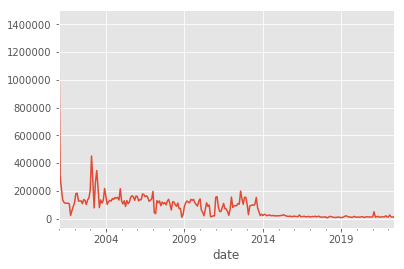

In [13]:
TX_oilf['GENERATION (Megawatthours)'].plot();

In [14]:
TX_oilg=TX_oilf.iloc[1: , :]

In [15]:
TX_oilg

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-02-01,TX,Total Electric Power Industry,Petroleum,303792.0
2001-03-01,TX,Total Electric Power Industry,Petroleum,213414.0
2001-04-01,TX,Total Electric Power Industry,Petroleum,133996.0
2001-05-01,TX,Total Electric Power Industry,Petroleum,117381.0
2001-06-01,TX,Total Electric Power Industry,Petroleum,110543.0
...,...,...,...,...
2022-01-01,TX,Total Electric Power Industry,Petroleum,12474.0
2022-02-01,TX,Total Electric Power Industry,Petroleum,26279.0
2022-03-01,TX,Total Electric Power Industry,Petroleum,13208.0


In [16]:
TX_oilg.index

DatetimeIndex(['2001-02-01', '2001-03-01', '2001-04-01', '2001-05-01',
               '2001-06-01', '2001-07-01', '2001-08-01', '2001-09-01',
               '2001-10-01', '2001-11-01',
               ...
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01'],
              dtype='datetime64[ns]', name='date', length=256, freq=None)

/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/vi/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


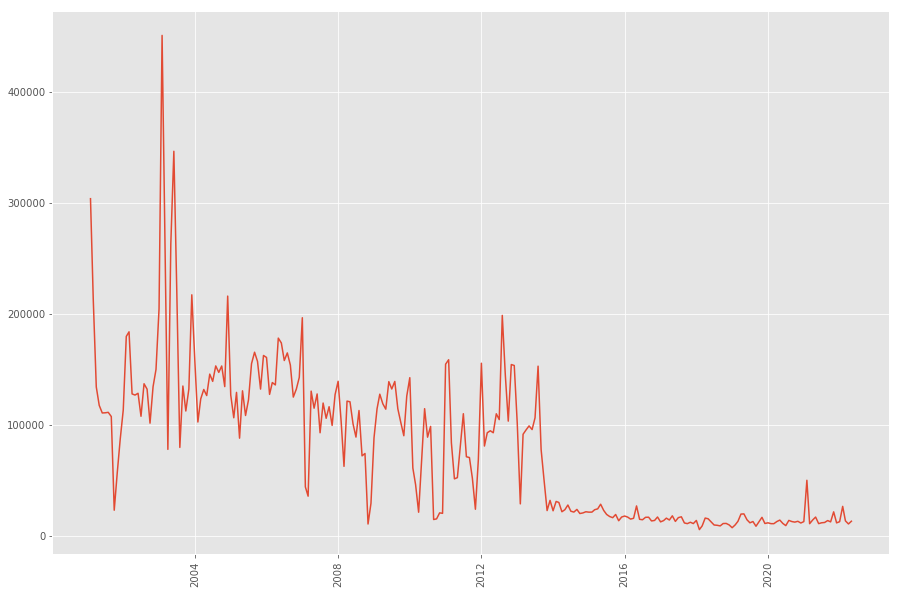

In [17]:
fig = plt.figure(figsize=(15,10))
#plt.plot(solar)
plt.plot(TX_oilg.index,TX_oilg['GENERATION (Megawatthours)'])
plt.xticks(rotation=90)
plt.show()

In [18]:
TX_sol=TX.loc[TX['ENERGY SOURCE']=='Solar Thermal and Photovoltaic']

In [19]:
TX_sol

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,TX,Total Electric Power Industry,Solar Thermal and Photovoltaic,0.0
2001-01-01,TX,"Electric Generators, Electric Utilities",Solar Thermal and Photovoltaic,0.0
2001-02-01,TX,Total Electric Power Industry,Solar Thermal and Photovoltaic,0.0
2001-02-01,TX,"Electric Generators, Electric Utilities",Solar Thermal and Photovoltaic,0.0
2001-03-01,TX,Total Electric Power Industry,Solar Thermal and Photovoltaic,0.0
...,...,...,...,...
2022-05-01,TX,Total Electric Power Industry,Solar Thermal and Photovoltaic,2114053.0
2022-05-01,TX,"Combined Heat and Power, Industrial Power",Solar Thermal and Photovoltaic,1173.0
2022-05-01,TX,"Combined Heat and Power, Commercial Power",Solar Thermal and Photovoltaic,400.0


In [20]:
TX_solt=TX_sol.loc[TX_sol['TYPE OF PRODUCER']=='Total Electric Power Industry']

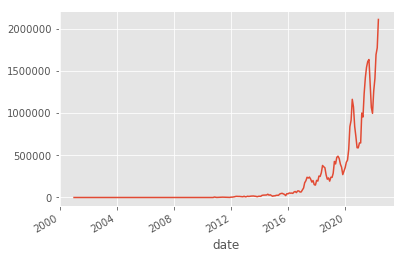

In [21]:
TX_solt['GENERATION (Megawatthours)'].plot();

In [22]:
solar=TX_solt['2012':]

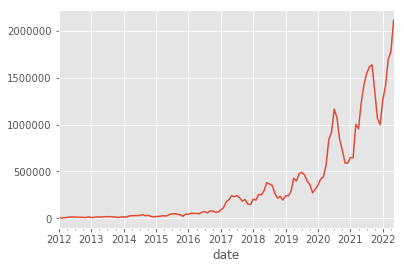

In [23]:
solar['GENERATION (Megawatthours)'].plot();

In [24]:
US_total=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']
US_total=US_total.loc[US_total['STATE']=='US-TOTAL']

#total_gen=data[data["STATE"]=="US-TOTAL"]
#total_gen=total_gen[(total_gen["TYPE OF PRODUCER"]!="Total Electric Power Industry")

In [25]:
US_total

,STATE,TYPE OF PRODUCER,ENERGY SOURCE,GENERATION (Megawatthours)
date,,,,
2001-01-01,US-TOTAL,Total Electric Power Industry,Coal,177287111.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Petroleum,18111843.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Natural Gas,42388663.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Other Gases,718442.0
2001-01-01,US-TOTAL,Total Electric Power Industry,Nuclear,68707077.0
...,...,...,...,...
2022-05-01,US-TOTAL,Total Electric Power Industry,Petroleum,1524488.0
2022-05-01,US-TOTAL,Total Electric Power Industry,Solar Thermal and Photovoltaic,15151118.0
2022-05-01,US-TOTAL,Total Electric Power Industry,Other Biomass,1440366.0


In [26]:
US_total['ENERGY SOURCE'].value_counts()

Nuclear                           257
Natural Gas                       257
Total                             257
Other Biomass                     257
Petroleum                         257
Other Gases                       257
Solar Thermal and Photovoltaic    257
Wind                              257
Geothermal                        257
Pumped Storage                    257
Wood and Wood Derived Fuels       257
Hydroelectric Conventional        257
Coal                              257
Other                             257
Name: ENERGY SOURCE, dtype: int64

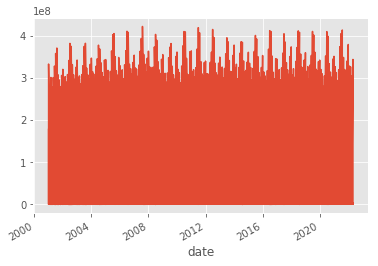

In [27]:
US_total['GENERATION (Megawatthours)'].plot();

In [28]:
US_total.groupby(['ENERGY SOURCE']).sum()

,GENERATION (Megawatthours)
ENERGY SOURCE,
Coal,3.373252e+10
Geothermal,3.276873e+08
Hydroelectric Conventional,5.808074e+09
Natural Gas,2.330229e+10
Nuclear,1.694104e+10
Other,2.793172e+08
Other Biomass,3.939717e+08
Other Gases,2.661957e+08
Petroleum,1.108598e+09


In [29]:
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

In [30]:
US_source

,date,ENERGY SOURCE,GENERATION (Megawatthours)
0,2001-01-01,Coal,177287111.0
1,2001-01-01,Geothermal,1229325.0
2,2001-01-01,Hydroelectric Conventional,18852048.0
3,2001-01-01,Natural Gas,42388663.0
4,2001-01-01,Nuclear,68707077.0
...,...,...,...
3593,2022-05-01,Pumped Storage,-466746.0
3594,2022-05-01,Solar Thermal and Photovoltaic,15151118.0
3595,2022-05-01,Total,343502190.0
3596,2022-05-01,Wind,41891907.0


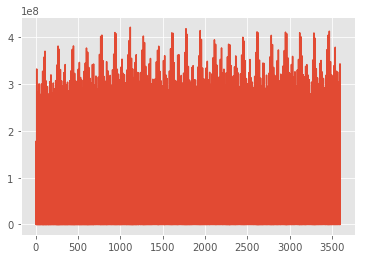

In [31]:
US_source['GENERATION (Megawatthours)'].plot();

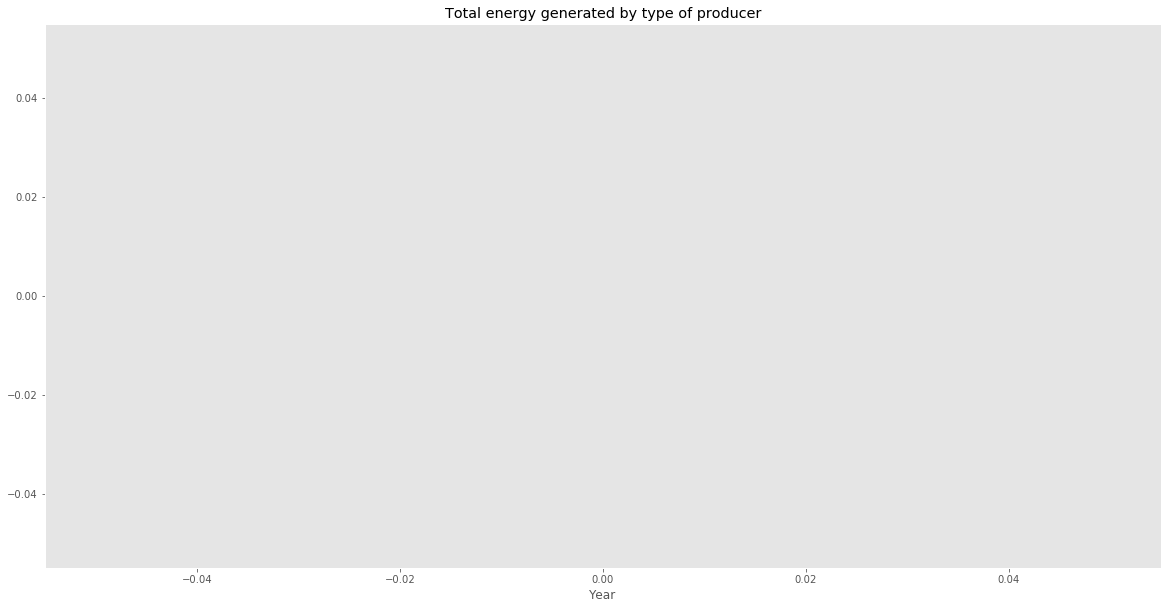

In [32]:
#Figsize
plt.figure(figsize=(20,10))
#Seaborn style
#sns.color_palette("tab10")
#Plot - using mdates for correct datetime format
#sns.scatterplot(data=US_source,
#                x="date",y="Generation (Megawatthours)",hue="ENERGY SOURCE").xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.plot(x="date",y="Generation (Megawatthours)", kind='line')
#Plot additional properties
plt.grid()
#plt.xticks([str(i+2001)+"-01-01" for i in range(22)])
plt.title("Total energy generated by type of producer")
plt.xlabel("Year")
plt.show();

In [33]:
plt.figure(figsize=(20,10))
#Seaborn style
sns.color_palette("tab10")
#Plot - using mdates for correct datetime format
sns.lineplot(data=pd.melt(US_source, ['ENERGY SOURCE']), x=US_source.index ,y="GENERATION (Megawatthours)",hue="ENERGY SOURCE")
#Plot additional properties
#plt.grid()
#plt.xticks([str(i+2001)+"-01-01" for i in range(22)])
#plt.title("Total energy generated by type of producer")
#plt.xlabel("Year");
plt.show()


ValueError: Could not interpret value `GENERATION (Megawatthours)` for parameter `y`

<Figure size 1440x720 with 0 Axes>

In [ ]:
data[data.index.duplicated()]

In [ ]:
from altair import *
fig = plt.figure(figsize=(15,10))
#plt.plot(solar)
plt.plot(US_total.index,US_total["GENERATION (Megawatthours)"], color=US_total['ENERGY SOURCE'] )
plt.xticks(rotation=90)
plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize=(15, 10))

grouped = US_total.groupby('ENERGY SOURCE').sum()
#for key, group in grouped:
#    group.plot(ax=ax, kind='line', x=US_total.index, y=US_total["GENERATION (Megawatthours)"], label=key)#, color=colors[key])
grouped.plot(subplots=False)
plt.show()

In [ ]:
grouped

its ok. Make it work.

The trends that have shown to be mor einteresting, with a change or trend over time are:
Coal, Petroleum, Natural Gas, Wind and Solar. So let us preview those.

In [ ]:
US_coal=US_total.loc[US_total['ENERGY SOURCE']=='Coal']

In [ ]:
US_coal.plot();

In [ ]:
US_oil=US_total.loc[US_total['ENERGY SOURCE']=='Petroleum']
US_oil.plot();

In [ ]:
US_nat=US_total.loc[US_total['ENERGY SOURCE']=='Natural Gas']
US_nat.plot();

In [ ]:
US_nat

In [ ]:
US_sol=US_total.loc[US_total['ENERGY SOURCE']=='Solar Thermal and Photovoltaic']
US_sol.plot();

In [ ]:
US_wind=US_total.loc[US_total['ENERGY SOURCE']=='Wind']
US_wind.plot();

In [ ]:
roll_mean = US_nat.rolling(window=8, center=False).mean()
roll_std = US_nat.rolling(window=8, center=False).std()

In [ ]:
fig = plt.figure(figsize=(12,7))
plt.plot(US_nat["GENERATION (Megawatthours)"], color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(US_nat["GENERATION (Megawatthours)"])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

In [ ]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

In [ ]:
#data=US_nat.drop(['STATE','TYPE OF PRODUCER','ENERGY SOURCE'], axis=1, inplace=True)
data=US_nat["GENERATION (Megawatthours)"]
roll_mean = US_nat['GENERATION (Megawatthours)'].rolling(window=2, center=False).mean()
# Subtract the moving average from the original data
data_minus_roll_mean = data - roll_mean
# Drop the missing values from time series calculated above
data_minus_roll_mean.dropna(inplace=True)
# Plot sales with rolling mean subtracted
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_roll_mean, color='blue')#,label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show();#(block=False)

In [ ]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = data.ewm(halflife=2).mean()
roll_std = data.ewm(halflife=2).std()
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(data, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.plot(roll_std, color='black', label = 'Exp Rolling Std')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = data - exp_roll_mean
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [ ]:
dftest = adfuller(data_minus_roll_mean)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

In [ ]:
dftest = adfuller(data_minus_exp_roll_mean)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Here maybe a paragraph in which you explain what it means, the fact that the residualas are stationary and why do we subract the rolling mean, because there is a dependence on the previous periods, specifically the amounts of periods specified in the window. And that expotential means the ones closer in time are more relevant then the others.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(data))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(data), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.isna().sum()

In [ ]:
residual.dropna(inplace=True)

In [ ]:
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

In [ ]:
#data_minus_exp_roll_mean

In [ ]:
""" THIS IS STILL A QUESTION IN TERMS OF DOES IT MAKE SENSE TO DO
DECOMPOSITION WITH data minus mean

decomposition = seasonal_decompose(np.log(data_minus_exp_roll_mean[2:]))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(data), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()"""

In [ ]:
wind=US_wind["GENERATION (Megawatthours)"]
oil=US_oil["GENERATION (Megawatthours)"]
nat=US_nat["GENERATION (Megawatthours)"]
sol=US_sol["GENERATION (Megawatthours)"]
coal=US_coal["GENERATION (Megawatthours)"]

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(wind))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(data), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

In [ ]:
decomposition = seasonal_decompose(np.log(sol))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(data), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

In [ ]:
decomposition = seasonal_decompose(np.log(oil))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(data), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

In [ ]:
decomposition = seasonal_decompose(np.log(coal))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(data), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)